# Name:- Sojas Khandagale¶
# GitHub UserName:- sojas07
# USC ID:- 4955206780

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os
import math
import statsmodels.api as sm
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, confusion_matrix, recall_score, pairwise_distances, ConfusionMatrixDisplay, precision_score, f1_score, classification_report, roc_auc_score, log_loss, accuracy_score, mean_squared_error
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import os
import shutil
import cv2
from PIL import Image,ImageOps,ImageEnhance
from PIL.ImageEnhance import Contrast, Brightness, Color, Sharpness
import random
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, EfficientNetB0, VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,  ModelCheckpoint
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import json
from tensorflow.data import Dataset
from keras.models import load_model

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


(d) Data Exploration and Pre-processing

1.Images in each class are given in separate folders in the folder Sport Images. We have several hundreds of images for five classes of sport activities, namely baseball, basketball, fencing, tennis, and volleyball.

2.Randomly select d0.7nie images from each folder as your training set, d0.15nie as validation set, and the rest as your test set, where ni is the number of images in folder i and dxe is the ceiling of x.

3.In order for all the images to have the same size, zero-pad or resize the images in your dataset. This can be done using various tools, including OpenCV.

In [8]:
train_prop = 0.7
val_prop = 0.15
test_prop = 0.15


sports_folder = ['training','validation','test','Image URLs']
images_folder = '../data/final_project/Sport Images'

train_path = os.path.join(images_folder,"training")
os.makedirs(train_path,exist_ok=True)

val_path = os.path.join(images_folder,"validation")
os.makedirs(val_path,exist_ok=True)

test_path = os.path.join(images_folder,"test")
os.makedirs(test_path,exist_ok=True)

for folder in os.listdir(images_folder):
  if str(folder) not in sports_folder:
    folder_path = os.path.join(images_folder, folder)
    number_images_in_folder = len(os.listdir(folder_path))
    
    train_size = int(np.ceil(number_images_in_folder * train_prop))
    val_size = int(np.ceil(number_images_in_folder * val_prop))
    test_size = number_images_in_folder - train_size - val_size

    indices = np.random.permutation(number_images_in_folder)
    train_indices = indices[:train_size]
    val_indices = indices[train_size:train_size+val_size]
    test_indices = indices[train_size+val_size:]

    train_class_path = os.path.join(train_path,folder)
    if not os.path.exists(train_class_path):
        os.makedirs(train_class_path,exist_ok=True)
    for idx in train_indices:
        filename = os.listdir(folder_path)[idx]
        new_filename = str(folder) + "_" + str(filename)
        # print(os.path.join(train_class_path, new_filename))
        shutil.copy(os.path.join(folder_path, filename), os.path.join(train_class_path, new_filename))

    val_class_path = os.path.join(val_path,folder)
    if not os.path.exists(val_class_path):
          os.makedirs(val_class_path,exist_ok=True)
    for idx in val_indices:
        filename = os.listdir(folder_path)[idx]
        new_filename = str(folder) + "_" + str(filename)
        shutil.copy(os.path.join(folder_path, filename), os.path.join(val_class_path, new_filename))

    test_class_path = os.path.join(test_path,folder)
    if not os.path.exists(test_class_path):
          os.makedirs(test_class_path,exist_ok=True)
    for idx in test_indices:
        filename = os.listdir(folder_path)[idx]
        new_filename = str(folder) + "_" + str(filename)
        shutil.copy(os.path.join(folder_path, filename), os.path.join(test_class_path, new_filename))

In [9]:
train_folder = '../data/final_project/Sport Images/training'
val_folder = '../data/final_project/Sport Images/validation'
test_folder = '../data/final_project/Sport Images/test'

width, height = 512, 512

def zeroPadImages(img,filename,folder_path):
    curr_height, curr_width = img.size
    pad_width = width - curr_width
    pad_height = height - curr_height
    padding = (0, 0, pad_width, pad_height)
    padded_img = ImageOps.expand(img, padding, fill=0)
    padded_img.save(os.path.join(folder_path, filename))


for folder in os.listdir(train_folder):
    img_folders = os.path.join(train_folder,folder)
    for img_file in os.listdir(img_folders):
    img = Image.open(os.path.join(img_folders, img_file))
    zeroPadImages(img,img_file,img_folders)

for folder in os.listdir(val_folder):
    img_folders = os.path.join(val_folder,folder)
    for img_file in os.listdir(img_folders):
    img = Image.open(os.path.join(img_folders, img_file))
    zeroPadImages(img,img_file,img_folders)

for folder in os.listdir(test_folder):
    img_folders = os.path.join(test_folder,folder)
    for img_file in os.listdir(img_folders):
    img = Image.open(os.path.join(img_folders, img_file))
    zeroPadImages(img,img_file,img_folders)

## (e) Transfer Learning for Image Classification

ii. To perform empirical regularization, crop, randomly zoom, rotate, flip, contrast, and translate images in your training set for image augmentation. You
can use various tools to do this, including OpenCV.

iii. Use ReLU activation functions in the last layer and a softmax layer, along
with batch normalization 4 and a dropout rate of 20% as well as ADAM
optimizer. Use multinomial cross entropy loss. You can try any batch size,
but a batch size of 5 seems reasonable.

iv. Train the networks ResNet50, EfficientNetB0, and VGG16 for at least 50
epochs (preferably 100 epochs) and perform early stopping using the validation set. Keep the network parameters that have the lowest validation error.Plot the training and validation errors vs. epochs.

v. Report the Confusion Matrix, Precision, Recall, Accuracy, and F1 score for
your model on both training and test sets. Remember that this is a multi-class
classification problem.

In [10]:
train_folder = '../data/final_project/Sport Images/training'

augmented_train = '../data/final_project/Sport Images/aug_training'
os.makedirs(augmented_train,exist_ok=True)

def cropImage(img,filename,folder_path):
    crop_size = (400, 400)
    img.save(os.path.join(folder_path, filename))
    if img.width >= crop_size[0] and img.height >= crop_size[1]:
    x = random.randint(0, img.width - crop_size[0])
    y = random.randint(0, img.height - crop_size[1])
    crop_box = (x, y, x + crop_size[0], y + crop_size[1])
    cropped_img = img.crop(crop_box)
    filename = "cropped_" + filename 
    cropped_img.save(os.path.join(folder_path, filename))

def zoomImage(img,filename,folder_path):
    zoom_factor = random.uniform(1.0, 1.5)
    resized_size = (int(img.width * zoom_factor), int(img.height * zoom_factor))
    resized_img = img.resize(resized_size)
    crop_box = (
    random.randint(0, resized_size[0] - img.width),
    random.randint(0, resized_size[1] - img.height),
    img.width,
    img.height,
    )
    zoomed_img = resized_img.crop(crop_box)
    filename = "zoom_" + filename 
    zoomed_img.save(os.path.join(folder_path, filename))

def flipImage(img,filename,folder_path):
    if random.random() < 0.5:
    fliped_img = img.transpose(method=Image.FLIP_LEFT_RIGHT)
    filename = "flipped_" + filename 
    fliped_img.save(os.path.join(folder_path,filename))

def rotateImage(img,filename,folder_path):
    angle = random.randint(-30, 30)
    rotated_img = img.rotate(angle, resample=Image.BICUBIC, expand=True)
    filename = "rotated_" + filename 
    rotated_img.save(os.path.join(folder_path,filename))

def contrastImage(img,filename,folder_path):
    if img.mode not in ("RGB", "RGBA"):
    img = img.convert("RGB")

    contrast_factor = random.uniform(0.5, 1.5)
    brightness_factor = random.uniform(0.5, 1.5)
    color_factor = random.uniform(0.5, 1.5)
    sharpness_factor = random.uniform(0.5, 1.5)

    o_img = ImageEnhance.Contrast(img).enhance(contrast_factor).convert(img.mode)
    o_img = ImageEnhance.Brightness(o_img).enhance(brightness_factor).convert(img.mode)
    o_img = ImageEnhance.Color(o_img).enhance(color_factor).convert(img.mode)
    o_img = ImageEnhance.Sharpness(o_img).enhance(sharpness_factor).convert(img.mode)

    if img.size == o_img.size:
    filename = "contrast_" + filename 
    o_img.save(os.path.join(folder_path,filename))


for folder in os.listdir(train_folder):
    augmented_folder_path = os.path.join(augmented_train,folder)
    os.makedirs(augmented_folder_path,exist_ok=True)
    img_files = os.path.join(train_folder,folder)
    for img_file in os.listdir(img_files):
    img = Image.open(os.path.join(img_files, img_file))
    cropImage(img,img_file,augmented_folder_path)
    zoomImage(img,img_file,augmented_folder_path)
    rotateImage(img,img_file,augmented_folder_path)
    flipImage(img,img_file,augmented_folder_path)
    contrastImage(img,img_file,augmented_folder_path)


iii. Use ReLU activation functions in the last layer and a softmax layer, along
with batch normalization 4 and a dropout rate of 20% as well as ADAM
optimizer. Use multinomial cross entropy loss. You can try any batch size,
but a batch size of 5 seems reasonable.

In [3]:
train_folder = '../data/final_project/Sport Images/aug_training'
validation_folder = '../data/final_project/Sport Images/validation'

IMG_SIZE = (256,256)
IMG_SHAPE = IMG_SIZE + (3,)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_folder,shuffle=True,batch_size=5,image_size=(256,256),labels='inferred',label_mode="categorical",class_names=None)
val_dataset = tf.keras.utils.image_dataset_from_directory(validation_folder,shuffle=True,batch_size=5,image_size=(256,256),labels='inferred',label_mode="categorical",class_names=None)
    
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('../data/final_project/best_resnet.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)
base_model = ResNet50(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(rate = 0.2)(x)
outputs = Dense(5, activation='softmax')(x)
f1_model = Model(inputs=base_model.input, outputs=outputs)
f1_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])

print("ResNet50\n")

resnet_history = f1_model.fit(train_dataset,epochs=50,validation_data=val_dataset,callbacks=[callback,checkpoint])

acc = resnet_history.history['accuracy']
val_acc = resnet_history.history['val_accuracy']

loss = resnet_history.history['loss']
val_loss = resnet_history.history['val_loss']

Found 10738 files belonging to 5 classes.
Found 495 files belonging to 5 classes.
94765736/94765736 [==============================] - 0s 0us/step
ResNet50

Epoch 1/50
2148/2148 [==============================] - ETA: 0s - loss: 0.7389 - accuracy: 0.7219
Epoch 1: val_loss improved from inf to 0.34243, saving model to best_resnet.h5
2148/2148 [==============================] - 60s 26ms/step - loss: 0.7389 - accuracy: 0.7219 - val_loss: 0.3424 - val_accuracy: 0.8768
Epoch 2/50
2146/2148 [============================>.] - ETA: 0s - loss: 0.4379 - accuracy: 0.8413
Epoch 2: val_loss improved from 0.34243 to 0.27940, saving model to best_resnet.h5
2148/2148 [==============================] - 47s 22ms/step - loss: 0.4378 - accuracy: 0.8413 - val_loss: 0.2794 - val_accuracy: 0.8909
Epoch 3/50
2146/2148 [============================>.] - ETA: 0s - loss: 0.3268 - accuracy: 0.8837
Epoch 3: val_loss did not improve from 0.27940
2148/2148 [==============================] - 47s 22ms/step - loss: 0.3

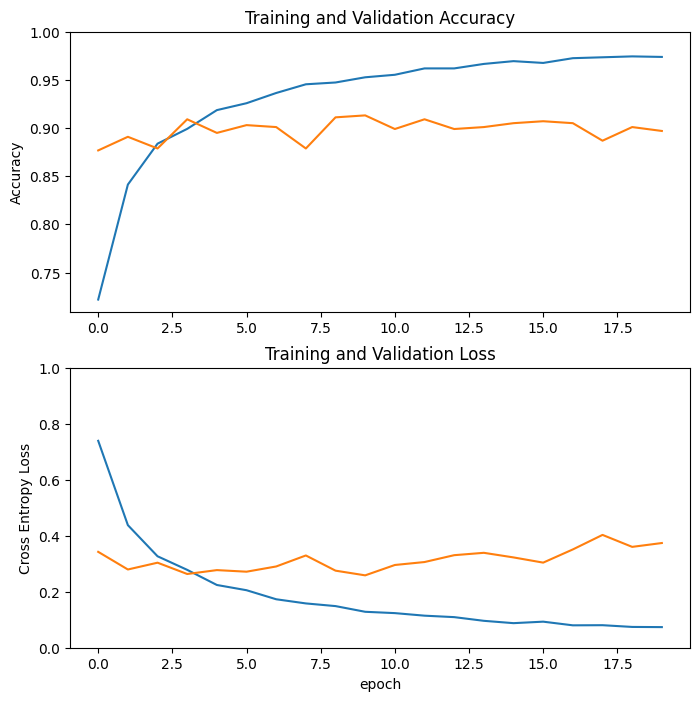

In [4]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylabel('Cross Entropy Loss')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [5]:
test_folder = '../data/final_project/Sport Images/test'
test_dataset = tf.keras.utils.image_dataset_from_directory(test_folder,shuffle=True,batch_size=5,labels='inferred',label_mode="categorical",class_names=None)

f1_model.load_weights('../data/final_project/best_resnet.h5')
loss, accuracy = f1_model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

Found 486 files belonging to 5 classes.
98/98 [==============================] - 3s 27ms/step - loss: 0.2933 - accuracy: 0.9198
Test accuracy : 0.9197530746459961


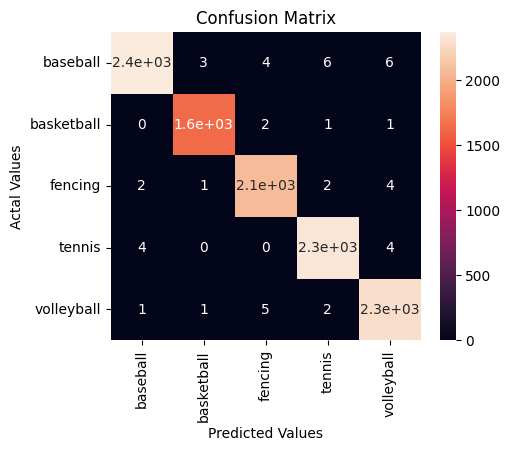

Precision:  0.9954396924206512
Recall:  0.9954367666232073
F1 Score:  0.9954363158088979


In [6]:
# For Training
y_preds = []
y_actuals = []
counter = 0
for batch in train_dataset:
    if counter == len(train_dataset):
        break
        
    image_batch, label_batch = batch
    logits = f1_model.predict_on_batch(image_batch)
    predictions = tf.nn.softmax(logits)
    y_pred = tf.argmax(predictions, axis=1)
    y_actual = np.argmax(label_batch, axis=1)
    
    y_preds.extend(y_pred)
    y_actuals.extend(y_actual)
    counter += 1


y_preds = np.array(y_preds)
y_actual = np.array(y_actuals)

class_labels = ['baseball', 'basketball', 'fencing', 'tennis', 'volleyball']

cm = confusion_matrix(y_actuals, y_preds, labels=range(len(class_labels)))
cm_df = pd.DataFrame(cm,
                     index = class_labels, 
                     columns = class_labels)

plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()


precision = precision_score(y_actuals, y_preds, average='weighted')
print("Precision: ",precision)
recall = recall_score(y_actuals,y_preds,average='weighted')
print("Recall: ", recall)
score_f1 = metrics.f1_score(y_actuals,y_preds,average='weighted')
print("F1 Score: ", score_f1)

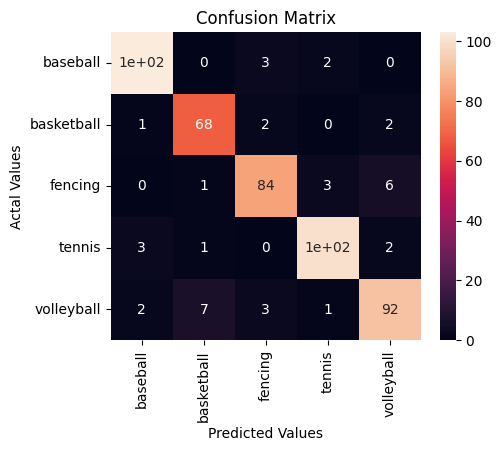

Precision:  0.9198653243797428
Recall:  0.9197530864197531
F1 Score:  0.919647266313933


In [7]:
# For Test
y_preds = []
y_actuals = []
counter = 0
for batch in test_dataset:
    if counter == len(test_dataset):
        break
        
    image_batch, label_batch = batch
    logits = f1_model.predict_on_batch(image_batch)
    predictions = tf.nn.softmax(logits)
    y_pred = tf.argmax(predictions, axis=1)
    y_actual = np.argmax(label_batch, axis=1)
    
    y_preds.extend(y_pred)
    y_actuals.extend(y_actual)
    counter += 1


y_preds = np.array(y_preds)
y_actual = np.array(y_actuals)

class_labels = ['baseball', 'basketball', 'fencing', 'tennis', 'volleyball']

cm = confusion_matrix(y_actuals, y_preds, labels=range(len(class_labels)))
cm_df = pd.DataFrame(cm,
                     index = class_labels, 
                     columns = class_labels)

plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()


precision = precision_score(y_actuals, y_preds, average='weighted')
print("Precision: ",precision)
recall = recall_score(y_actuals,y_preds,average='weighted')
print("Recall: ", recall)
score_f1 = metrics.f1_score(y_actuals,y_preds,average='weighted')
print("F1 Score: ", score_f1)

In [3]:
train_folder = '../data/final_project/Sport Images/aug_training'
validation_folder = '../data/final_project/Sport Images/validation'

IMG_SIZE = (256,256)
IMG_SHAPE = IMG_SIZE + (3,)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_folder,shuffle=True,batch_size=5,image_size=(256,256),labels='inferred',label_mode="categorical",class_names=None)
val_dataset = tf.keras.utils.image_dataset_from_directory(validation_folder,shuffle=True,batch_size=5,image_size=(256,256),labels='inferred',label_mode="categorical",class_names=None)
    
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('../data/final_project/best_effnet.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)


eff_base_model = EfficientNetB0(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')

for layer in eff_base_model.layers:
    layer.trainable = False

x = eff_base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(rate = 0.2)(x)
outputs = Dense(5, activation='softmax')(x)
f2_model = Model(inputs=eff_base_model.input, outputs=outputs)
f2_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])

print("EfficientNet50\n")

effnet_history = f2_model.fit(train_dataset,epochs=50,validation_data=val_dataset,callbacks=[callback,checkpoint])


eff_acc = effnet_history.history['accuracy']
eff_val_acc = effnet_history.history['val_accuracy']

eff_loss = effnet_history.history['loss']
eff_val_loss = effnet_history.history['val_loss']

Found 10738 files belonging to 5 classes.
Found 495 files belonging to 5 classes.
16719872/16705208 [==============================] - 0s 0us/step
EfficientNet50

Epoch 1/50
2148/2148 [==============================] - ETA: 0s - loss: 0.4967 - accuracy: 0.8242
Epoch 1: val_loss improved from inf to 0.14648, saving model to best_effnet.h5
2148/2148 [==============================] - 62s 24ms/step - loss: 0.4967 - accuracy: 0.8242 - val_loss: 0.1465 - val_accuracy: 0.9556
Epoch 2/50
2147/2148 [============================>.] - ETA: 0s - loss: 0.2858 - accuracy: 0.9024
Epoch 2: val_loss improved from 0.14648 to 0.14561, saving model to best_effnet.h5
2148/2148 [==============================] - 45s 21ms/step - loss: 0.2858 - accuracy: 0.9024 - val_loss: 0.1456 - val_accuracy: 0.9535
Epoch 3/50
2145/2148 [============================>.] - ETA: 0s - loss: 0.1998 - accuracy: 0.9319
Epoch 3: val_loss improved from 0.14561 to 0.12573, saving model to best_effnet.h5
2148/2148 [=================

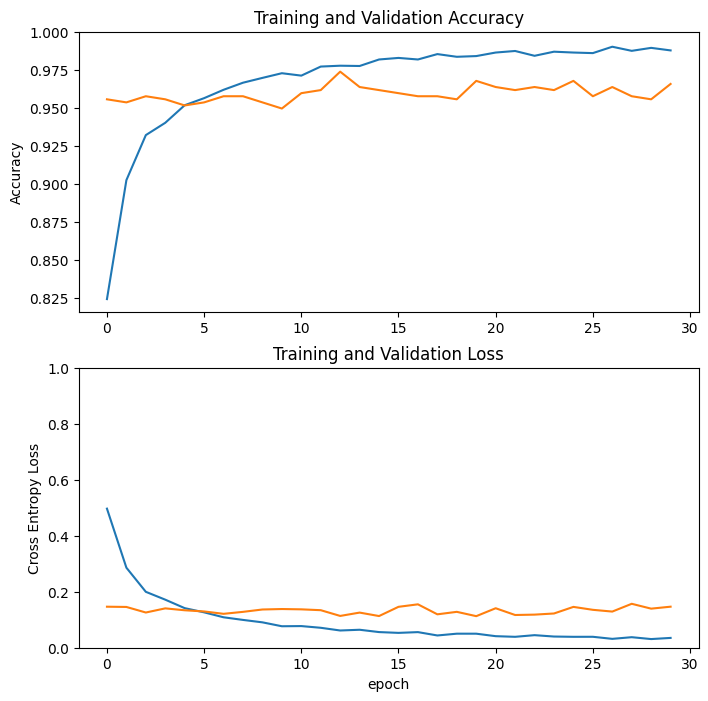

In [4]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(eff_acc, label='Training Accuracy')
plt.plot(eff_val_acc, label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(eff_loss, label='Training Loss')
plt.plot(eff_val_loss, label='Validation Loss')
plt.ylabel('Cross Entropy Loss')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [5]:
test_folder = '../data/final_project/Sport Images/test'
test_dataset = tf.keras.utils.image_dataset_from_directory(test_folder,shuffle=True,batch_size=5,labels='inferred',label_mode="categorical",class_names=None)

f2_model.load_weights('../data/final_project/best_effnet.h5')
loss, accuracy = f2_model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

Found 486 files belonging to 5 classes.
98/98 [==============================] - 3s 27ms/step - loss: 0.1856 - accuracy: 0.9630
Test accuracy : 0.9629629850387573


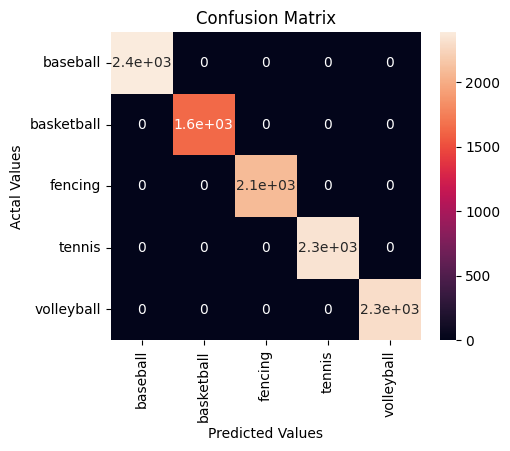

Precision:  1.0
Recall:  1.0
F1 Score:  1.0


In [6]:
# For Training
y_preds = []
y_actuals = []
counter = 0
for batch in train_dataset:
    if counter == len(train_dataset):
        break
        
    image_batch, label_batch = batch
    logits = f2_model.predict_on_batch(image_batch)
    predictions = tf.nn.softmax(logits)
    y_pred = tf.argmax(predictions, axis=1)
    y_actual = np.argmax(label_batch, axis=1)
    
    y_preds.extend(y_pred)
    y_actuals.extend(y_actual)
    counter += 1


y_preds = np.array(y_preds)
y_actual = np.array(y_actuals)

class_labels = ['baseball', 'basketball', 'fencing', 'tennis', 'volleyball']

cm = confusion_matrix(y_actuals, y_preds, labels=range(len(class_labels)))
cm_df = pd.DataFrame(cm,
                     index = class_labels, 
                     columns = class_labels)

plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()


precision = precision_score(y_actuals, y_preds, average='weighted')
print("Precision: ",precision)
recall = recall_score(y_actuals,y_preds,average='weighted')
print("Recall: ", recall)
score_f1 = metrics.f1_score(y_actuals,y_preds,average='weighted')
print("F1 Score: ", score_f1)

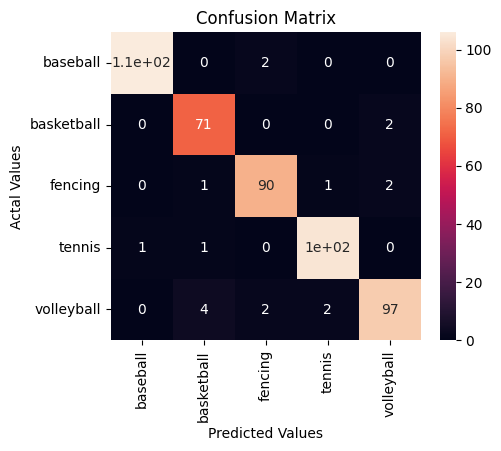

Precision:  0.9633167984750806
Recall:  0.9629629629629629
F1 Score:  0.9629525147269826


In [7]:
# For Test
y_preds = []
y_actuals = []
counter = 0
for batch in test_dataset:
    if counter == len(test_dataset):
        break
        
    image_batch, label_batch = batch
    logits = f2_model.predict_on_batch(image_batch)
    predictions = tf.nn.softmax(logits)
    y_pred = tf.argmax(predictions, axis=1)
    y_actual = np.argmax(label_batch, axis=1)
    
    y_preds.extend(y_pred)
    y_actuals.extend(y_actual)
    counter += 1


y_preds = np.array(y_preds)
y_actual = np.array(y_actuals)

class_labels = ['baseball', 'basketball', 'fencing', 'tennis', 'volleyball']

cm = confusion_matrix(y_actuals, y_preds, labels=range(len(class_labels)))
cm_df = pd.DataFrame(cm,
                     index = class_labels, 
                     columns = class_labels)

plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()


precision = precision_score(y_actuals, y_preds, average='weighted')
print("Precision: ",precision)
recall = recall_score(y_actuals,y_preds,average='weighted')
print("Recall: ", recall)
score_f1 = metrics.f1_score(y_actuals,y_preds,average='weighted')
print("F1 Score: ", score_f1)

In [12]:
train_folder = '../data/final_project/Sport Images/aug_training'
validation_folder = '../data/final_project/Sport Images/validation'

IMG_SIZE = (256,256)
IMG_SHAPE = IMG_SIZE + (3,)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_folder,shuffle=True,batch_size=5,image_size=(256,256),labels='inferred',label_mode="categorical",class_names=None)
val_dataset = tf.keras.utils.image_dataset_from_directory(validation_folder,shuffle=True,batch_size=5,image_size=(256,256),labels='inferred',label_mode="categorical",class_names=None)
    
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('../data/final_project/best_vgg.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

vgg_base_model = VGG16(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')

for layer in vgg_base_model.layers:
    layer.trainable = False

x = vgg_base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(rate = 0.2)(x)
outputs = Dense(5, activation='softmax')(x)
f3_model = Model(inputs=vgg_base_model.input, outputs=outputs)
f3_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])

print("VGG 16\n")

vgg_history = f3_model.fit(train_dataset,epochs=50,validation_data=val_dataset,callbacks=[callback,checkpoint])

vgg_acc = vgg_history.history['accuracy']
vgg_val_acc = vgg_history.history['val_accuracy']

vgg_loss = vgg_history.history['loss']
vgg_val_loss = vgg_history.history['val_loss']

Found 10738 files belonging to 5 classes.
Found 495 files belonging to 5 classes.
58889256/58889256 [==============================] - 0s 0us/step
VGG 16

Epoch 1/50
2148/2148 [==============================] - ETA: 0s - loss: 1.0026 - accuracy: 0.6148
Epoch 1: val_loss improved from inf to 0.51219, saving model to best_vgg.h5
2148/2148 [==============================] - 49s 22ms/step - loss: 1.0026 - accuracy: 0.6148 - val_loss: 0.5122 - val_accuracy: 0.8303
Epoch 2/50
2147/2148 [============================>.] - ETA: 0s - loss: 0.6701 - accuracy: 0.7528
Epoch 2: val_loss improved from 0.51219 to 0.42124, saving model to best_vgg.h5
2148/2148 [==============================] - 46s 21ms/step - loss: 0.6700 - accuracy: 0.7528 - val_loss: 0.4212 - val_accuracy: 0.8566
Epoch 3/50
2146/2148 [============================>.] - ETA: 0s - loss: 0.5654 - accuracy: 0.7980
Epoch 3: val_loss improved from 0.42124 to 0.39174, saving model to best_vgg.h5
2148/2148 [==============================] - 

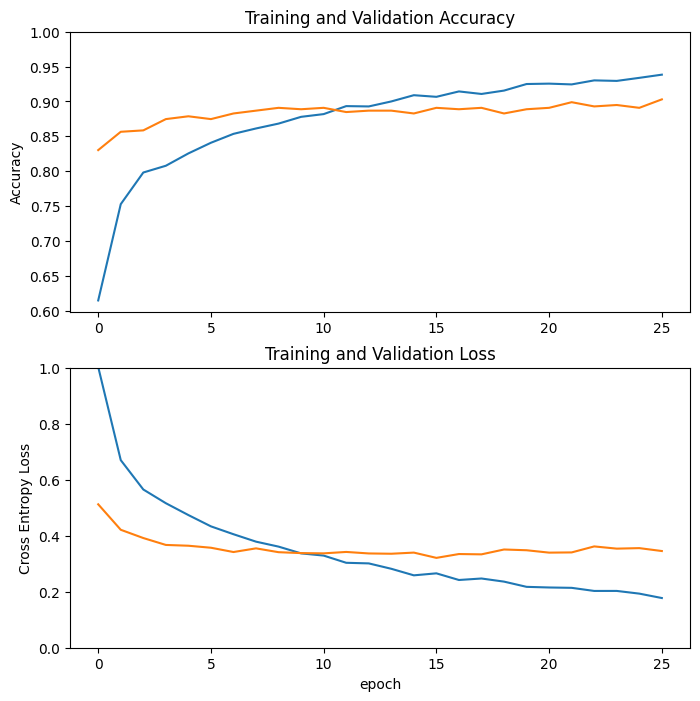

In [13]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(vgg_acc, label='Training Accuracy')
plt.plot(vgg_val_acc, label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(vgg_loss, label='Training Loss')
plt.plot(vgg_val_loss, label='Validation Loss')
plt.ylabel('Cross Entropy Loss')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [14]:
test_folder = '../data/final_project/Sport Images/test'
test_dataset = tf.keras.utils.image_dataset_from_directory(test_folder,shuffle=True,batch_size=5,labels='inferred',label_mode="categorical",class_names=None)

f3_model.load_weights('../data/final_project/best_vgg.h5')
loss, accuracy = f3_model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

Found 486 files belonging to 5 classes.
98/98 [==============================] - 2s 21ms/step - loss: 0.3309 - accuracy: 0.8786
Test accuracy : 0.8786008358001709


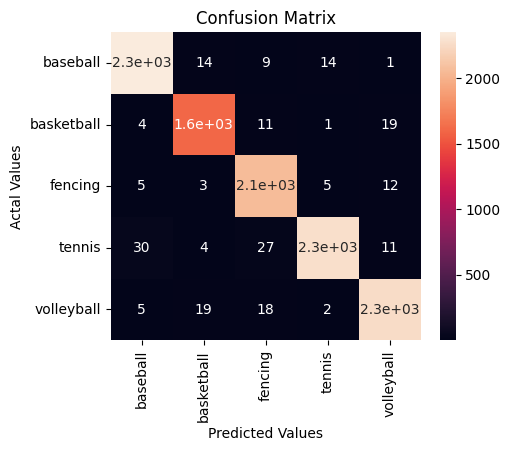

Precision:  0.9801601025512536
Recall:  0.9800707766809462
F1 Score:  0.9800726507235841


In [15]:
# For Training
y_preds = []
y_actuals = []
counter = 0
for batch in train_dataset:
    if counter == len(train_dataset):
        break
        
    image_batch, label_batch = batch
    logits = f3_model.predict_on_batch(image_batch)
    predictions = tf.nn.softmax(logits)
    y_pred = tf.argmax(predictions, axis=1)
    y_actual = np.argmax(label_batch, axis=1)
    
    y_preds.extend(y_pred)
    y_actuals.extend(y_actual)
    counter += 1


y_preds = np.array(y_preds)
y_actual = np.array(y_actuals)

class_labels = ['baseball', 'basketball', 'fencing', 'tennis', 'volleyball']

cm = confusion_matrix(y_actuals, y_preds, labels=range(len(class_labels)))
cm_df = pd.DataFrame(cm,
                     index = class_labels, 
                     columns = class_labels)

plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()


precision = precision_score(y_actuals, y_preds, average='weighted')
print("Precision: ",precision)
recall = recall_score(y_actuals,y_preds,average='weighted')
print("Recall: ", recall)
score_f1 = metrics.f1_score(y_actuals,y_preds,average='weighted')
print("F1 Score: ", score_f1)

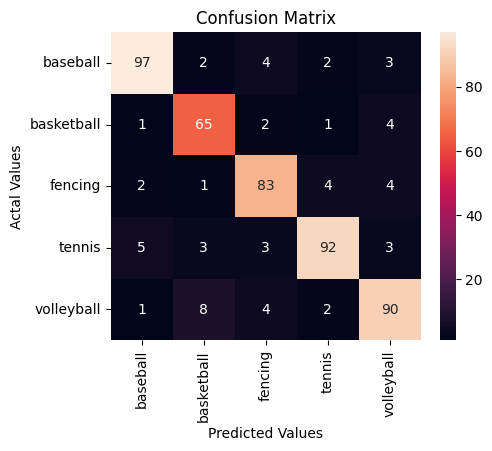

Precision:  0.879802784388371
Recall:  0.8786008230452675
F1 Score:  0.8788475567976458


In [16]:
# For Test
y_preds = []
y_actuals = []
counter = 0
for batch in test_dataset:
    if counter == len(test_dataset):
        break
        
    image_batch, label_batch = batch
    logits = f3_model.predict_on_batch(image_batch)
    predictions = tf.nn.softmax(logits)
    y_pred = tf.argmax(predictions, axis=1)
    y_actual = np.argmax(label_batch, axis=1)
    
    y_preds.extend(y_pred)
    y_actuals.extend(y_actual)
    counter += 1


y_preds = np.array(y_preds)
y_actual = np.array(y_actuals)

class_labels = ['baseball', 'basketball', 'fencing', 'tennis', 'volleyball']

cm = confusion_matrix(y_actuals, y_preds, labels=range(len(class_labels)))
cm_df = pd.DataFrame(cm,
                     index = class_labels, 
                     columns = class_labels)

plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()


precision = precision_score(y_actuals, y_preds, average='weighted')
print("Precision: ",precision)
recall = recall_score(y_actuals,y_preds,average='weighted')
print("Recall: ", recall)
score_f1 = metrics.f1_score(y_actuals,y_preds,average='weighted')
print("F1 Score: ", score_f1)

### (f) Video Classification Using Moving Averages

i. In order to have a better deep learner, reuse the validation and test data and
train the network, without seriously overfitting it. In the lectures, we saw
how this can be done.

ii. Apply at least L equally spaced frames of each video in the folder Sport
Videos5 to your model to obtain L vectors of probability predictions from
the softmax in your model. You must choose L to be at least 100, but you
are welcome to use all the frames in each video. Calculate the average p¯ of
these probability vectors for each video.

iii. Select the class with maximum probability in the vector p¯ for each video and
compare it to the actual label of the video.

iv. Report the Confusion Matrix, Precision, Recall, Accuracy, and F1 score for
your model on the test data, i.e. videos. Remember that this is a multi-class
classification problem.

In [1]:
# Merged preivious validation and test data and the again splited them into validation and test of size 70 and 30 for reusing

merged_val_test = '../data/final_project/Sport Images/val_test'
if not os.path.exists(merged_val_test):
    os.makedirs(merged_val_test)
    
test_folder = '../data/final_project/Sport Images/test'
val_folder = '../data/final_project/Sport Images/validation'

for folder in os.listdir(test_folder):
    sports_folder = os.path.join(test_folder,folder)
    merged_sports_folder = os.path.join(merged_val_test,folder)
    if not os.path.exists(merged_sports_folder):
        os.makedirs(merged_sports_folder)
    for img_file in  os.listdir(sports_folder):
        shutil.copy(os.path.join(sports_folder, img_file), os.path.join(merged_sports_folder, img_file))  

        
for folder in os.listdir(val_folder):
    sports_folder = os.path.join(val_folder,folder)
    merged_sports_folder = os.path.join(merged_val_test,folder)
    if not os.path.exists(merged_sports_folder):
        os.makedirs(merged_sports_folder)
    for img_file in  os.listdir(sports_folder):
        shutil.copy(os.path.join(sports_folder, img_file), os.path.join(merged_sports_folder, img_file))  

In [6]:
test_prop = 0.3
val_prop = 0.7


sports_folder = ['training','validation','test','Image URLs']
images_folder = '../data/final_project/Sport Images/val_test'
base_folder = '../data/final_project/Sport Images/Sport Images/'

val_path = os.path.join(base_folder,"val_updated")
os.makedirs(val_path,exist_ok=True)

test_path = os.path.join(base_folder,"test_updated")
os.makedirs(test_path,exist_ok=True)

for folder in os.listdir(images_folder):
    folder_path = os.path.join(images_folder, folder)
    number_images_in_folder = len(os.listdir(folder_path))

    val_size = int(np.ceil(number_images_in_folder * val_prop))
    test_size = int(np.ceil(number_images_in_folder * test_prop))

    indices = np.random.permutation(number_images_in_folder)
    val_indices = indices[:val_size]
    test_indices = indices[val_size:]

    val_class_path = os.path.join(val_path,folder)
    if not os.path.exists(val_class_path):
    os.makedirs(val_class_path,exist_ok=True)
    for idx in val_indices:
    filename = os.listdir(folder_path)[idx]
    new_filename = str(folder) + "_" + str(filename)
    shutil.copy(os.path.join(folder_path, filename), os.path.join(val_class_path, new_filename))

    test_class_path = os.path.join(test_path,folder)
    if not os.path.exists(test_class_path):
    os.makedirs(test_class_path,exist_ok=True)
    for idx in test_indices:
    filename = os.listdir(folder_path)[idx]
    new_filename = str(folder) + "_" + str(filename)
    shutil.copy(os.path.join(folder_path, filename), os.path.join(test_class_path, new_filename))

In [2]:
# For Resnet
IMG_SIZE = (256,256)
IMG_SHAPE = IMG_SIZE + (3,)

val_folder = '../data/final_project/Sport Images/val_updated'
test_folder = '../data/final_project/Sport Images/test_updated'

val_dataset = tf.keras.utils.image_dataset_from_directory(val_folder,shuffle=True,batch_size=5,image_size=(256,256),labels='inferred',label_mode="categorical",class_names=None)
test_dataset = tf.keras.utils.image_dataset_from_directory(test_folder,shuffle=False,batch_size=5,image_size=(256,256),labels='inferred',label_mode="categorical",class_names=None)
    
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('../data/final_project/new_best_resnet.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

resnet_retrain_model = load_model('../data/final_project/best_resnet.h5')
resnet_retrain_model.fit(val_dataset,epochs=50,validation_data=test_dataset,callbacks=[callback,checkpoint])

Found 684 files belonging to 5 classes.
Found 297 files belonging to 5 classes.
Epoch 1/50
137/137 [==============================] - ETA: 0s - loss: 0.2337 - accuracy: 0.9225
Epoch 1: val_loss improved from inf to 0.09807, saving model to new_best_resnet.h5
137/137 [==============================] - 15s 53ms/step - loss: 0.2337 - accuracy: 0.9225 - val_loss: 0.0981 - val_accuracy: 0.9630
Epoch 2/50
136/137 [============================>.] - ETA: 0s - loss: 0.1734 - accuracy: 0.9456
Epoch 2: val_loss improved from 0.09807 to 0.07661, saving model to new_best_resnet.h5
137/137 [==============================] - 4s 32ms/step - loss: 0.1724 - accuracy: 0.9459 - val_loss: 0.0766 - val_accuracy: 0.9697
Epoch 3/50
135/137 [============================>.] - ETA: 0s - loss: 0.1118 - accuracy: 0.9630
Epoch 3: val_loss did not improve from 0.07661
137/137 [==============================] - 4s 28ms/step - loss: 0.1108 - accuracy: 0.9635 - val_loss: 0.0784 - val_accuracy: 0.9663
Epoch 4/50
137/137

In [3]:
video_dir = '../data/final_project/Sport Videos'

class_labels = ['BaseballPitch','Basketball','Fencing','TennisSwing','VolleyballSpiking']

num_frames = 100

avg_probs = []
predicted_labels = []
actual_labels = []

for folder in os.listdir(video_dir):
    video_folders = os.path.join(video_dir,folder)
    for video_file in os.listdir(video_folders):
        video_path = os.path.join(video_folders, video_file)
        video = cv2.VideoCapture(video_path)
        num_total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
        indices = np.linspace(0, num_total_frames-1, num=num_frames, dtype=np.int32)
        frames = []

        for idx in indices:
            video.set(cv2.CAP_PROP_POS_FRAMES, idx)
            ret, frame = video.read()
            if not ret:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = cv2.resize(frame, (256, 256))
            frames.append(frame)

        frames = np.array(frames)

        frames = tf.keras.applications.resnet50.preprocess_input(frames)
        probs = resnet_retrain_model.predict(frames)

        avg_probs.append(np.mean(probs, axis=0))
        
        predicted_label_index = np.argmax(avg_probs[-1])
        predicted_label = class_labels[predicted_label_index]
        actual_label = folder

        predicted_labels.append(predicted_label)
        actual_labels.append(actual_label)

4/4 [==============================] - 0s 65ms/step


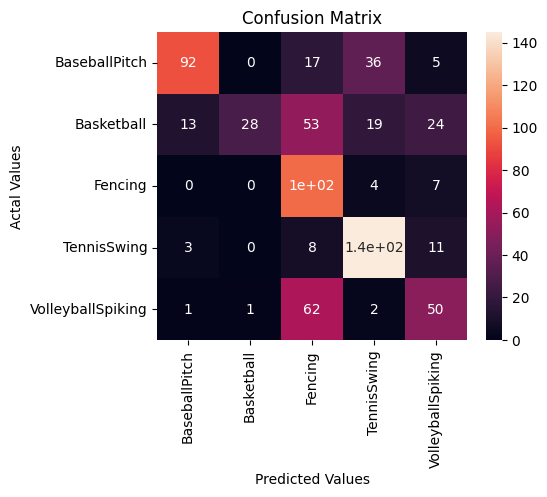

Precision:  0.7084783036394002
Recall:  0.6093979441997063
F1 Score:  0.5878526773411391
Accuracy:  0.6093979441997063


In [10]:
label_map = {label: i for i, label in enumerate(class_labels)}

actual_labels_int = [label_map[label] for label in actual_labels]
predicted_labels_int = [label_map[label] for label in predicted_labels]

cm = tf.math.confusion_matrix(actual_labels_int, predicted_labels_int)
cm_df = pd.DataFrame(cm,
                     index = class_labels, 
                     columns = class_labels)

plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

precision = precision_score(actual_labels, predicted_labels, average='weighted')
print("Precision: ",precision)
recall = recall_score(actual_labels,predicted_labels,average='weighted')
print("Recall: ", recall)
score_f1 = metrics.f1_score(actual_labels,predicted_labels,average='weighted')
print("F1 Score: ", score_f1)
accuracy = accuracy_score(actual_labels, predicted_labels)
print("Accuracy: ", accuracy)

In [6]:
# For EffecientNet

val_folder = '../data/final_project/Sport Images/val_updated'
test_folder = '../data/final_project/Sport Images/test_updated'

val_dataset = tf.keras.utils.image_dataset_from_directory(val_folder,shuffle=True,batch_size=5,image_size=(256,256),labels='inferred',label_mode="categorical",class_names=None)
test_dataset = tf.keras.utils.image_dataset_from_directory(test_folder,shuffle=False,batch_size=5,image_size=(256,256),labels='inferred',label_mode="categorical",class_names=None)
    
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('../data/final_project/new_best_effnet.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

effnet_retrain_model = load_model('../data/final_project/best_effnet.h5')
effnet_retrain_model.fit(val_dataset,epochs=50,validation_data=test_dataset,callbacks=[callback,checkpoint])

Found 684 files belonging to 5 classes.
Found 297 files belonging to 5 classes.
Epoch 1/50


2023-05-08 20:39:23.988846: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


135/137 [============================>.] - ETA: 0s - loss: 0.1055 - accuracy: 0.9570
Epoch 1: val_loss improved from inf to 0.03891, saving model to new_best_effnet.h5
137/137 [==============================] - 9s 41ms/step - loss: 0.1050 - accuracy: 0.9576 - val_loss: 0.0389 - val_accuracy: 0.9865
Epoch 2/50
134/137 [============================>.] - ETA: 0s - loss: 0.0832 - accuracy: 0.9687
Epoch 2: val_loss improved from 0.03891 to 0.03582, saving model to new_best_effnet.h5
137/137 [==============================] - 4s 26ms/step - loss: 0.0816 - accuracy: 0.9693 - val_loss: 0.0358 - val_accuracy: 0.9832
Epoch 3/50
137/137 [==============================] - ETA: 0s - loss: 0.0649 - accuracy: 0.9795
Epoch 3: val_loss did not improve from 0.03582
137/137 [==============================] - 3s 21ms/step - loss: 0.0649 - accuracy: 0.9795 - val_loss: 0.0422 - val_accuracy: 0.9798
Epoch 4/50
136/137 [============================>.] - ETA: 0s - loss: 0.0485 - accuracy: 0.9809
Epoch 4: val_l

In [7]:
video_dir = '../data/final_project/Sport Videos'

class_labels = ['BaseballPitch','Basketball','Fencing','TennisSwing','VolleyballSpiking']

num_frames = 100

effnet_avg_probs = []
effnet_predicted_labels = []
effnet_actual_labels = []

for folder in os.listdir(video_dir):
    video_folders = os.path.join(video_dir,folder)
    for video_file in os.listdir(video_folders):
        video_path = os.path.join(video_folders, video_file)
        video = cv2.VideoCapture(video_path)
        num_total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
        indices = np.linspace(0, num_total_frames-1, num=num_frames, dtype=np.int32)
        frames = []

        for idx in indices:
            video.set(cv2.CAP_PROP_POS_FRAMES, idx)
            ret, frame = video.read()
            if not ret:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = cv2.resize(frame, (256, 256))
            frames.append(frame)

        frames = np.array(frames)

        frames = tf.keras.applications.resnet50.preprocess_input(frames)
        probs = effnet_retrain_model.predict(frames)

        effnet_avg_probs.append(np.mean(probs, axis=0))
        
        predicted_label_index = np.argmax(effnet_avg_probs[-1])
        predicted_label = class_labels[predicted_label_index]
        actual_label = folder

        effnet_predicted_labels.append(predicted_label)
        effnet_actual_labels.append(actual_label)

4/4 [==============================] - 0s 45ms/step


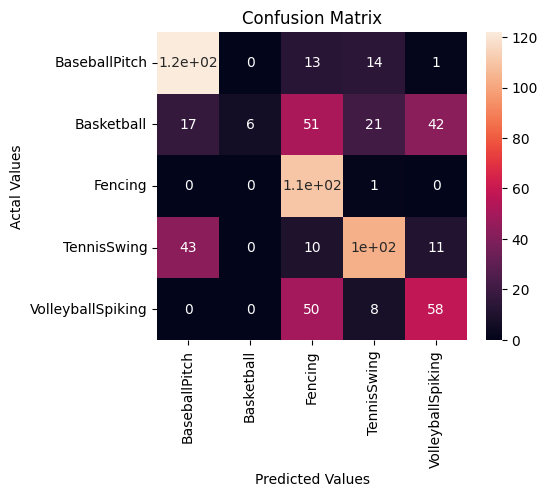

Precision:  0.6854830715749531
Recall:  0.5859030837004405
F1 Score:  0.5302468861400391
Accuracy:  0.5859030837004405


In [8]:
label_map = {label: i for i, label in enumerate(class_labels)}

actual_labels_int = [label_map[label] for label in effnet_actual_labels]
predicted_labels_int = [label_map[label] for label in effnet_predicted_labels]

cm = tf.math.confusion_matrix(actual_labels_int, predicted_labels_int)
cm_df = pd.DataFrame(cm,
                     index = class_labels, 
                     columns = class_labels)

plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

precision = precision_score(effnet_actual_labels, effnet_predicted_labels, average='weighted')
print("Precision: ",precision)
recall = recall_score(effnet_actual_labels,effnet_predicted_labels,average='weighted')
print("Recall: ", recall)
score_f1 = metrics.f1_score(effnet_actual_labels,effnet_predicted_labels,average='weighted')
print("F1 Score: ", score_f1)
accuracy = accuracy_score(effnet_actual_labels, effnet_predicted_labels)
print("Accuracy: ", accuracy)

In [2]:
# For VGG16

val_folder = '../data/final_project/Sport Images/val_updated'
test_folder = '../data/final_project/Sport Images/test_updated'

val_dataset = tf.keras.utils.image_dataset_from_directory(val_folder,shuffle=True,batch_size=5,image_size=(256,256),labels='inferred',label_mode="categorical",class_names=None)
test_dataset = tf.keras.utils.image_dataset_from_directory(test_folder,shuffle=False,batch_size=5,image_size=(256,256),labels='inferred',label_mode="categorical",class_names=None)
    
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('../data/final_project/new_best_vgg.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

vgg_retrain_model = load_model('../data/final_project/best_vgg.h5')
vgg_retrain_model.fit(val_dataset,epochs=50,validation_data=test_dataset,callbacks=[callback,checkpoint])

Found 684 files belonging to 5 classes.
Found 297 files belonging to 5 classes.
Epoch 1/50
137/137 [==============================] - ETA: 0s - loss: 0.4379 - accuracy: 0.8480
Epoch 1: val_loss improved from inf to 0.13421, saving model to new_best_vgg.h5
137/137 [==============================] - 12s 40ms/step - loss: 0.4379 - accuracy: 0.8480 - val_loss: 0.1342 - val_accuracy: 0.9428
Epoch 2/50
136/137 [============================>.] - ETA: 0s - loss: 0.2923 - accuracy: 0.8853
Epoch 2: val_loss improved from 0.13421 to 0.12213, saving model to new_best_vgg.h5
137/137 [==============================] - 4s 30ms/step - loss: 0.2967 - accuracy: 0.8830 - val_loss: 0.1221 - val_accuracy: 0.9495
Epoch 3/50
136/137 [============================>.] - ETA: 0s - loss: 0.2423 - accuracy: 0.9059
Epoch 3: val_loss did not improve from 0.12213
137/137 [==============================] - 4s 28ms/step - loss: 0.2418 - accuracy: 0.9064 - val_loss: 0.1254 - val_accuracy: 0.9461
Epoch 4/50
136/137 [====

In [4]:
video_dir = '../data/final_project/Sport Videos'

class_labels = ['BaseballPitch','Basketball','Fencing','TennisSwing','VolleyballSpiking']

num_frames = 100

vgg_avg_probs = []
vgg_predicted_labels = []
vgg_actual_labels = []

for folder in os.listdir(video_dir):
    video_folders = os.path.join(video_dir,folder)
    for video_file in os.listdir(video_folders):
        video_path = os.path.join(video_folders, video_file)
        video = cv2.VideoCapture(video_path)
        num_total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
        indices = np.linspace(0, num_total_frames-1, num=num_frames, dtype=np.int32)
        frames = []

        for idx in indices:
            video.set(cv2.CAP_PROP_POS_FRAMES, idx)
            ret, frame = video.read()
            if not ret:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = cv2.resize(frame, (256, 256))
            frames.append(frame)

        frames = np.array(frames)

        frames = tf.keras.applications.resnet50.preprocess_input(frames)
        probs = vgg_retrain_model.predict(frames)

        vgg_avg_probs.append(np.mean(probs, axis=0))
        
        predicted_label_index = np.argmax(vgg_avg_probs[-1])
        predicted_label = class_labels[predicted_label_index]
        actual_label = folder

        vgg_predicted_labels.append(predicted_label)
        vgg_actual_labels.append(actual_label)

4/4 [==============================] - 0s 73ms/step


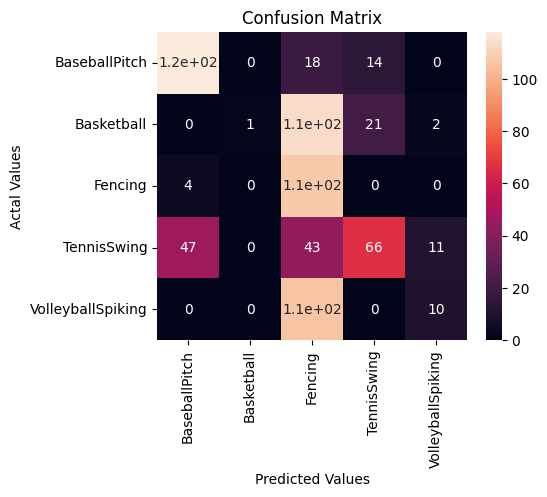

Precision:  0.6343423579607251
Recall:  0.4434654919236417
F1 Score:  0.3812047989519141
Accuracy:  0.4434654919236417


In [5]:
label_map = {label: i for i, label in enumerate(class_labels)}

actual_labels_int = [label_map[label] for label in vgg_actual_labels]
predicted_labels_int = [label_map[label] for label in vgg_predicted_labels]

cm = tf.math.confusion_matrix(actual_labels_int, predicted_labels_int)
cm_df = pd.DataFrame(cm,
                     index = class_labels, 
                     columns = class_labels)

plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

precision = precision_score(vgg_actual_labels, vgg_predicted_labels, average='weighted')
print("Precision: ",precision)
recall = recall_score(vgg_actual_labels,vgg_predicted_labels,average='weighted')
print("Recall: ", recall)
score_f1 = metrics.f1_score(vgg_actual_labels,vgg_predicted_labels,average='weighted')
print("F1 Score: ", score_f1)
accuracy = accuracy_score(vgg_actual_labels, vgg_predicted_labels)
print("Accuracy: ", accuracy)